In [1]:
import pandas as pd
import numpy as np

from dotenv import load_dotenv
from bs4 import BeautifulSoup

import torch
import requests

import os

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

rates = requests.get("https://api.exchangerate-api.com/v4/latest/USD").json()['rates']
rates['RUR'] = rates['RUB']
rates['BYR'] = rates['BYN']

Select either embedding or vllm

In [2]:
from sentence_transformers import SentenceTransformer

# embedding_model = SentenceTransformer("intfloat/multilingual-e5-large", trust_remote_code=True).cuda()
embedding_model = SentenceTransformer("dunzhang/stella_en_1.5B_v5", trust_remote_code=True).cuda()
# embedding_model = SentenceTransformer("deepvk/USER-bge-m3", trust_remote_code=True).cuda()

/home/netkit/Projects/analytics/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
from vllm import LLM, SamplingParams

os.environ["VLLM_ATTENTION_BACKEND"] = "FLASHINFER"
os.environ["HF_TOKEN"] = os.environ['HF_TOKEN']

llm = LLM("google/gemma-2-2b-it")

# model_id = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit"
# model_id = "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit"
# llm = LLM(model=model_id, dtype=torch.bfloat16, trust_remote_code=True, quantization="bitsandbytes", load_format="bitsandbytes", max_model_len=4096)

WARNING 10-04 02:54:47 utils.py:747] Gemma 2 uses sliding window attention for every odd layer, which is currently not supported by vLLM. Disabling sliding window and capping the max length to the sliding window size (4096).
INFO 10-04 02:54:47 llm_engine.py:226] Initializing an LLM engine (v0.6.1.dev238+ge2c6e0a82) with config: model='google/gemma-2-2b-it', speculative_config=None, tokenizer='google/gemma-2-2b-it', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 10-04 02:54:52 model_runner.py:1025] Loading model weights took 4.8999 GB
INFO 10-04 02:54:55 gpu_executor.py:122] # GPU blocks: 1434, # CPU blocks: 2520
INFO 10-04 02:54:55 model_runner.py:1329] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 10-04 02:54:55 model_runner.py:1333] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 10-04 02:55:11 model_runner.py:1456] Graph capturing finished in 16 secs.


In [3]:
df = pd.read_parquet('generated_nlp_features_v5.2_final.parquet')
df.shape

(20859, 30)

In [2]:
import glob

file_paths = glob.glob('full_vacs*.parquet')

dfs = []

for file_path in file_paths:
    df_temp = pd.read_parquet(file_path)
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)
df = df.drop_duplicates(subset='id')
df = df[['id', 'name', 'area', 'address', 'salary', 'experience', 'description', 'key_skills', 'professional_roles', 'published_at', 'languages', 'employer', 'schedule', 'employment']]

df['area'] = df['area'].apply(lambda area: area['name'])
df['currency'] = df['salary'].apply(lambda salary: salary['currency'])
df['experience'] = df['experience'].apply(lambda exp: exp['name'])
df['key_skills'] = df['key_skills'].apply(lambda ks: list(map(lambda s: s['name'].lower(), ks)))
df['professional_roles'] = df['professional_roles'].apply(lambda prs: list(map(lambda pr: pr['name'], prs))[0])
df['published_at'] = pd.to_datetime(df['published_at'])
df['published_date'] = df['published_at'].dt.date
df['description'] = df['description'].apply(lambda desc: BeautifulSoup(desc).get_text().lower())
df['employer'] = df['employer'].apply(lambda employer: employer['name'])

df['salary_from'] = df['salary'].apply(lambda salary: salary['from'])
df['salary_to'] = df['salary'].apply(lambda salary: salary['to'])
df['employment'] = df['employment'].apply(lambda employment: employment['id'])
df['schedule'] = df['schedule'].apply(lambda sch: sch['id'])

salary_range_pct = 25.0

def calculate_mean_salary(row, pct):
    if pd.notna(row['salary_from']) and pd.notna(row['salary_to']):
        return (row['salary_from'] + row['salary_to']) / 2
    elif pd.notna(row['salary_from']):
        return row['salary_from'] * (1 + pct / 100)
    elif pd.notna(row['salary_to']):
        return row['salary_to'] * (1 - pct / 100)
    else:
        return np.nan


df['mean_salary'] = df.apply(lambda row: calculate_mean_salary(row, salary_range_pct), axis=1)
df['mean_salary_usd'] = df.apply(lambda row: row['mean_salary'] / rates[row['currency']], axis=1)

df = df.drop(columns=['address'])

area_counts = df['area'].value_counts()
areas_with_more_than_10_entries = area_counts[area_counts > 10].index

df = df[df['area'].isin(areas_with_more_than_10_entries)]

currency_counts = df['currency'].value_counts()
currency_with_more_than_100_entries = currency_counts[currency_counts > 100].index

df = df[df['currency'].isin(currency_with_more_than_100_entries)]

# If vacancy contains word высшее or higher than we can assume that higher education is required
df['education'] = df['description'].apply(lambda desc: int("высшее" in desc or "higher" in desc))

df.sort_values(by='mean_salary_usd', inplace=True)

# Fix salaries where thouthands are ommited
df.loc[(df['currency'].isin(['RUR', 'KZT'])) & (df['mean_salary_usd'] < 10), 'mean_salary_usd'] *= 1000
# remove 1 quantile because it's not representative
df = df[(df['mean_salary_usd'] >= df['mean_salary_usd'].quantile(0.01))]

/tmp/ipykernel_161508/3696150073.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['description'] = df['description'].apply(lambda desc: BeautifulSoup(desc).get_text().lower())


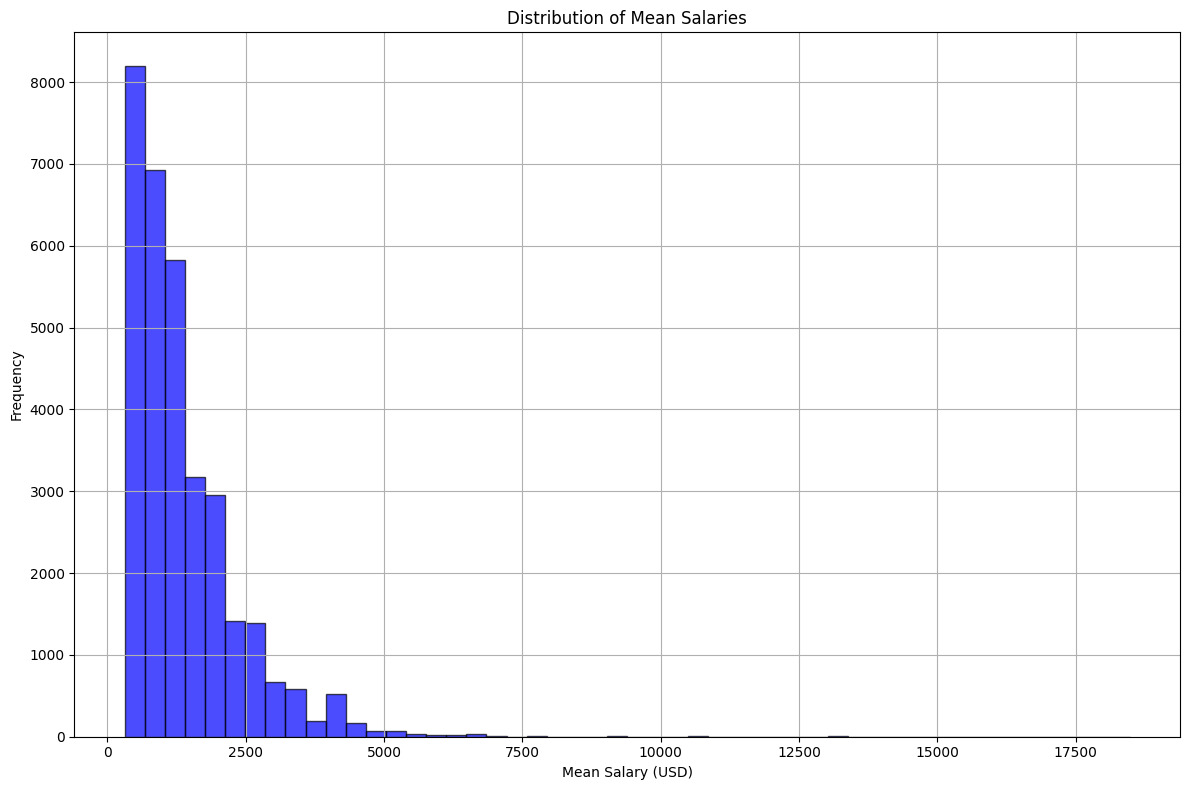

In [3]:
plt.figure(figsize=(12, 8))
plt.hist(df[df['employment'].eq('full')]['mean_salary_usd'].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')

plt.xlabel('Mean Salary (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Salaries')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

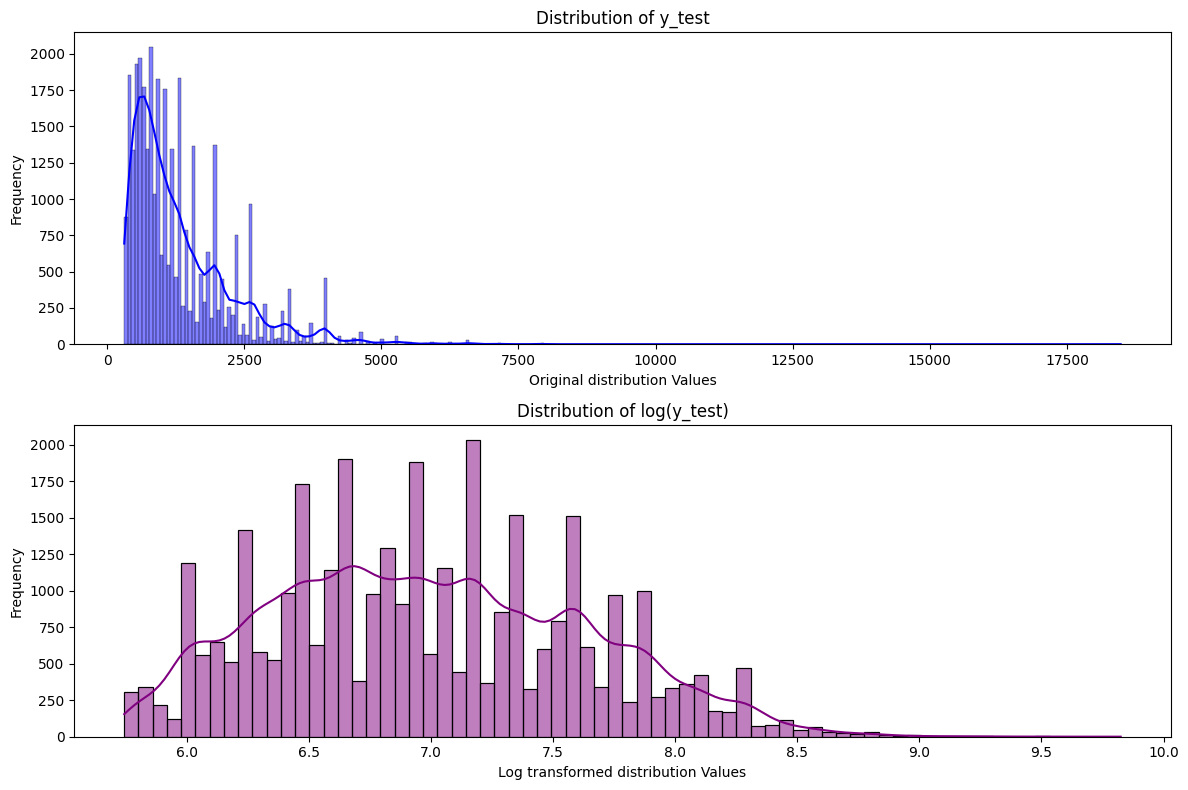

<Figure size 640x480 with 0 Axes>

In [4]:
plt.figure(figsize=(12, 8))
plt.figure(figsize=(12, 8))

# Plot original distribution
plt.subplot(2, 1, 1)
sns.histplot(df['mean_salary_usd'], kde=True, color='blue')
plt.xlabel('Original distribution Values')
plt.ylabel('Frequency')
plt.title('Distribution of y_test')

# Plot log-transformed distribution
plt.subplot(2, 1, 2)
sns.histplot(np.log(df['mean_salary_usd']), kde=True, color='purple')
plt.xlabel('Log transformed distribution Values')
plt.ylabel('Frequency')
plt.title('Distribution of log(y_test)')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

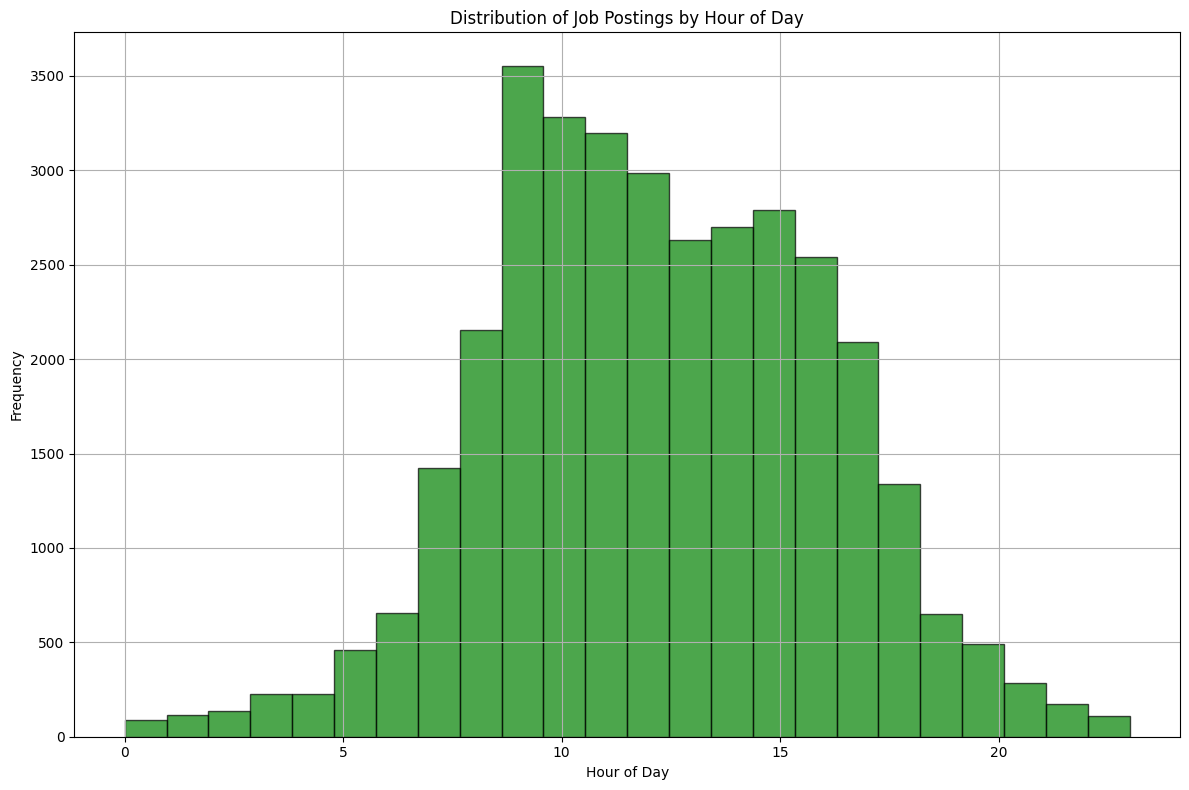

In [5]:
plt.figure(figsize=(12, 8))
plt.hist(pd.to_datetime(df['published_at']).dt.hour, bins=24, alpha=0.7, color='green', edgecolor='black')

plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Distribution of Job Postings by Hour of Day')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1600x1000 with 0 Axes>

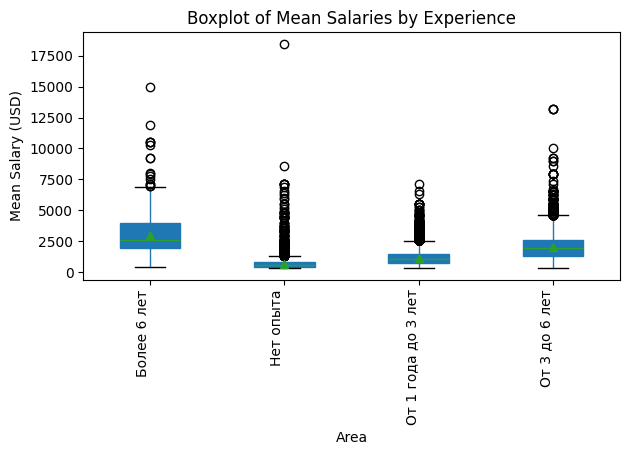

In [6]:
plt.figure(figsize=(16, 10))
df.boxplot(column='mean_salary_usd', by='experience', grid=False, vert=True, patch_artist=True, showmeans=True)

plt.xlabel('Area')
plt.ylabel('Mean Salary (USD)')
plt.title('Boxplot of Mean Salaries by Experience')
plt.suptitle('')  # Suppress the default title to avoid overlap
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

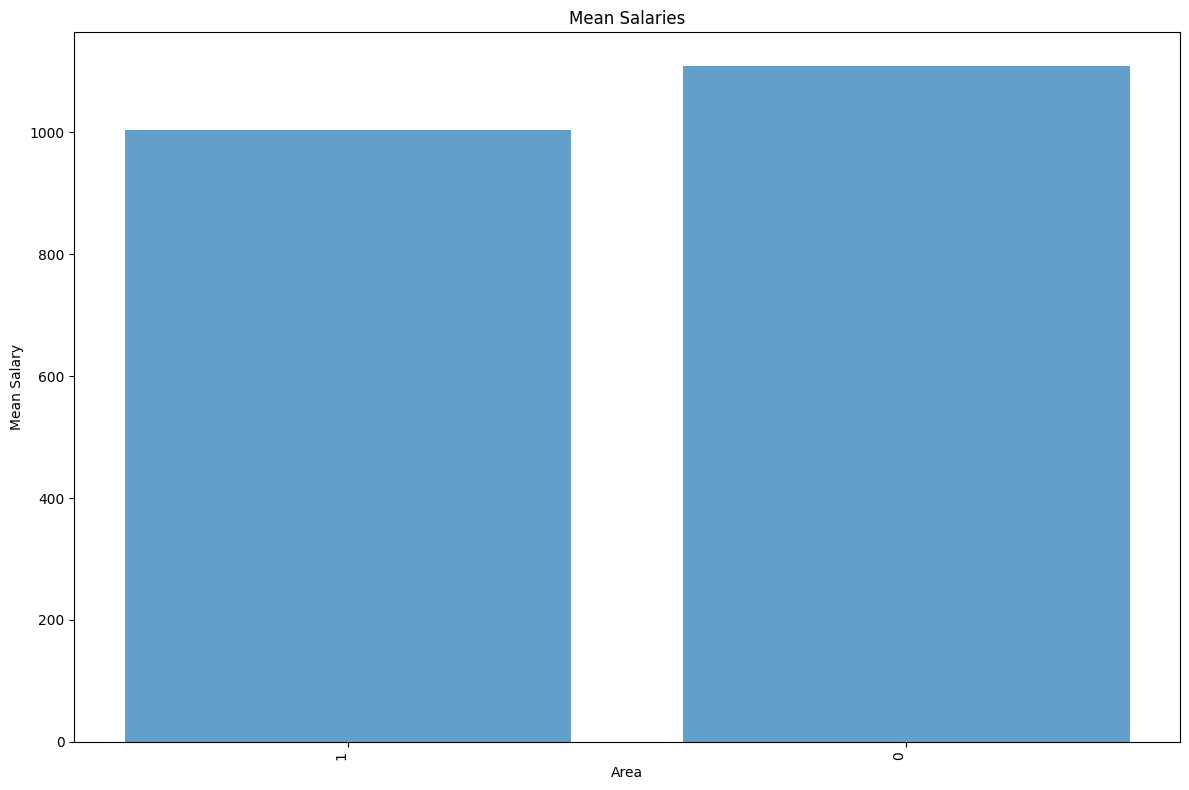

In [43]:
area_mean_salary = df.groupby('education')['mean_salary_usd'].median().sort_values(ascending=False)

# Plotting the mean salaries by area
plt.figure(figsize=(12, 8))
plt.bar(area_mean_salary.index, area_mean_salary.values, alpha=0.7)

plt.xlabel('Area')
plt.ylabel('Mean Salary')
plt.title('Mean Salaries')
plt.xticks(ticks=range(len(area_mean_salary.index)), labels=area_mean_salary.index, rotation=90, ha='right')
plt.tight_layout()
plt.show()


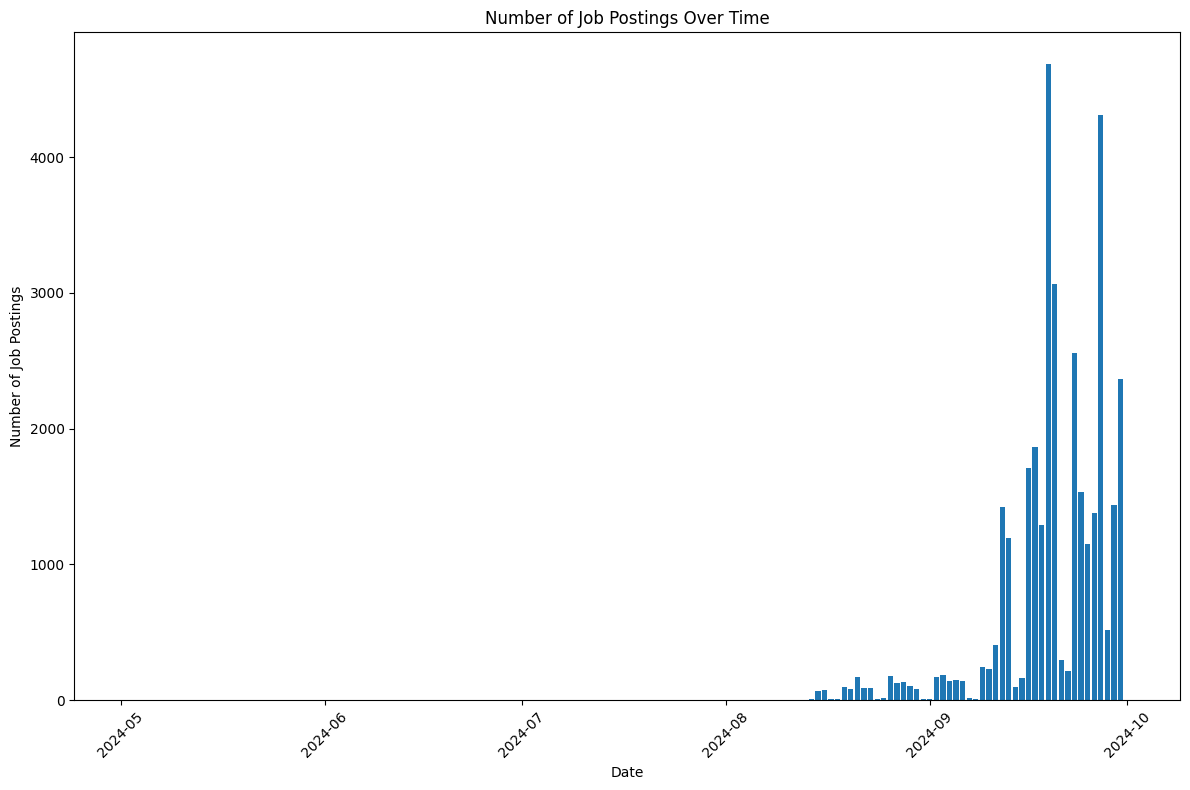

In [45]:
published_date_counts = df.groupby('published_date').size()

plt.figure(figsize=(12, 8))
plt.bar(published_date_counts.index, published_date_counts.values)

plt.xlabel('Date')
plt.ylabel('Number of Job Postings')
plt.title('Number of Job Postings Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
sampling_params = SamplingParams(temperature=0, top_p=0.95, max_tokens=512, repetition_penalty=1.0)

In [5]:
def prompt_template(template_params, model_name="gemma"):
    if "llama" in model_name.lower():
        return f"""
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert HR.
<|eot_id|><|start_header_id|>user<|end_header_id|>
{template_params}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""
    elif "gemma" in model_name.lower():
        return f"""<start_of_turn>user
You are an expert HR.
{template_params}
<end_of_turn>
<start_of_turn>model
"""
    elif "mistral" in model_name.lower():
        return f"""<s>[INST] You are an expert HR. 
{template_params} [/INST]
"""

In [ ]:
def build_summary_prompt(description):
    return prompt_template(f"""
You are an exper HR
Summarize the following job description in English, preserving only key details. Keep it concise:
Return only summary, do not add any additional info or headers. Do not add formatting
{description}
""", model_name="gemma")

print("Generating English summaries of job descriptions")
result = llm.generate([build_summary_prompt(desc) for desc in df['description']], sampling_params)

df['description_summary_en'] = [res.outputs[0].text.strip() for res in result]

In [ ]:
def build_data_role_prompt(name: str):
    return prompt_template(f"""
Here is a description of job vacancy. You need to determine if this vacancy is for an IT role.
Return only 1 or 0. DO NOT ADD ANY ADDITIONAL INFO
Description: {name}
""")

print("Generate data role feature")
result = llm.generate([build_data_role_prompt(name) for name in df['description_summary_en']], sampling_params)

df['is_it'] = [int(res.outputs[0].text.strip() == '1') for res in result]

In [ ]:
def build_customer_area_prompt(params):
    return prompt_template(f"""
You need to determine the customer location based on the job description.
If location is not specified assume that it is Russia.
Return only the country name. DO NOT ADD ANY ADDITIONAL INFO
Job Title: {params[0]}
Job Description: {params[1]}
""")

print("Generate customer area feature")
result = llm.generate(list(map(build_customer_area_prompt, list(zip(df['name'], df['description_summary_en'])))), sampling_params)

df['customer_area'] = [res.outputs[0].text.strip().lower() for res in result]


def build_industry_prompt(params):
    return prompt_template(f"""
You are an expert HR. You need to determine company industry
Example of industries: technology, medicine, transportation, manufacturing, ecommerce, food etc
Name: {params[0]}
Description: {params[1]}
RETURN ONLY INDUSTRY. USE ONLY ENGLISH NAMES. DO NOT ADD ADDITIONAL INFO/FORMATTING
""")

print("Generate industry feature")
result = llm.generate(list(map(build_industry_prompt,  list(zip(df['name'], df['description_summary_en'])))), sampling_params)

df['industry'] = [res.outputs[0].text.strip().lower() for res in result]

def build_manager_prompt(name: str):
    return prompt_template(f"""
Here is a name of job vacancy. You need too determine if this is a manager role
Return only 1 or 0
Name: {name}
""")

print("Generate manager feature")
result = llm.generate(list(map(build_manager_prompt, list(df['name']))), sampling_params)

df['manager'] = [int(res.outputs[0].text.strip().lower() == '1') for res in result]

def build_work_type_prompt(params):
    return prompt_template(f"""
Here is a description of job vacancy. Return the work type that best describes this vacancy.
Name: {params[0]}
Description: {params[1]}
Return one work type from in office, remote, hybrid.
RETURN WORK TYPE ONLY FROM LIST ABOVE. DO NOT ADD ANY OTHER INFORMATION. USE ONLY ENGLISH
""")

print("Generate work type feature")
result = llm.generate(list(map(build_work_type_prompt, list(zip(df['name'], df['description_summary_en'])))), sampling_params)

df['work_type'] = [res.outputs[0].text.strip().lower() for res in result]

def build_seniority_prompt(params):
    return prompt_template(f"""
Here is a description of job vacancy. Return the seniority level that best describes this vacancy.
Name: {params[0]}
Description: {params[1]}
Return one seniority level from intern, junior, middle, senior, lead, director.
RETURN LEVEL ONLY FROM LIST ABOVE. DO NOT ADD ANY OTHER INFORMATION. USE ONLY ENGLISH
""")

print("Generate seniority feature")
result = llm.generate(list(map(build_seniority_prompt, list(zip(df['name'], df['description_summary_en'])))), sampling_params)

df['seniority'] = [res.outputs[0].text.strip().lower() for res in result]

In [6]:
def build_techstack_prompt(params):
    return prompt_template(f"""
Extract the required technical skills from the following job vacancy:
DO NOT ADD ANY ADDITIONAL FORMATTING.
Return only list of required technical skills in format:
skill_1|skill_2|skill_n
use only english
Job Title: {params[0]}
Job Description: {params[1]}
""", model_name='gemma')


print("Generate tech skills feature")
result = llm.generate(list(map(build_techstack_prompt, list(zip(df['name'], df['description_summary_en'])))), sampling_params)

def parse_techstack(string: str):
    skills = [tech.strip() for tech in string.split('|')]
    return [tech for tech in skills if len(tech) >= 2]

df['tech_skills_v3'] = [parse_techstack(res.outputs[0].text.strip().lower()) for res in result]

def build_role_prompt(params):
    return prompt_template(f"""
You need to decide which role will candidate for this job perform
Select one from roles: Software Engineer, ML Engineer, ML OPS, Data Scientist, Data Analyst, Data Engineer, Dev OPS, Team Lead, Tech Support
Name: {params[0]}
Description: {params[1]}
DO NOT ADD LANGUAGE OR SOFTWARE TO ROLE NAME. DO NOT ADD ANY ADDITIONAL INFO
USE ONLY ENGLISH
Return only role
""", model_name='gemma')

print("Generate roles feature")
result = llm.generate(list(map(build_role_prompt, list(zip(df['name'], df['description_summary_en'])))), sampling_params)

df['role'] = [res.outputs[0].text.strip().lower() for res in result]

Generate tech skills feature


Processed prompts:   0%|          | 0/20859 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 10-04 02:56:14 scheduler.py:1439] Sequence group 127 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1


Processed prompts:  20%|█▉        | 4084/20859 [01:18<05:02, 55.53it/s, est. speed input: 9106.18 toks/s, output: 887.89 toks/s]

WARNING 10-04 02:57:31 scheduler.py:1439] Sequence group 4217 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=51


Processed prompts:  36%|███▌      | 7504/20859 [02:31<04:21, 51.00it/s, est. speed input: 8812.93 toks/s, output: 912.91 toks/s]

WARNING 10-04 02:58:44 scheduler.py:1439] Sequence group 7617 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=101


Processed prompts:  56%|█████▌    | 11684/20859 [04:08<03:30, 43.53it/s, est. speed input: 8593.86 toks/s, output: 941.28 toks/s]

WARNING 10-04 03:00:20 scheduler.py:1439] Sequence group 11788 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=151


Processed prompts:  81%|████████  | 16852/20859 [06:15<01:31, 43.71it/s, est. speed input: 8387.81 toks/s, output: 957.67 toks/s]

WARNING 10-04 03:02:28 scheduler.py:1439] Sequence group 16950 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=201


Processed prompts: 100%|██████████| 20859/20859 [07:57<00:00, 43.69it/s, est. speed input: 8297.66 toks/s, output: 971.54 toks/s] 


Generate roles feature


Processed prompts:   4%|▎         | 771/20859 [00:14<05:49, 57.51it/s, est. speed input: 10531.32 toks/s, output: 273.25 toks/s]

WARNING 10-04 03:04:37 scheduler.py:1439] Sequence group 21839 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=251


Processed prompts:  66%|██████▋   | 13832/20859 [03:56<01:41, 69.31it/s, est. speed input: 11969.37 toks/s, output: 299.11 toks/s]

WARNING 10-04 03:08:18 scheduler.py:1439] Sequence group 34790 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=301


Processed prompts: 100%|██████████| 20859/20859 [06:04<00:00, 57.25it/s, est. speed input: 12017.24 toks/s, output: 293.11 toks/s] 


In [11]:
df.to_parquet('generated_nlp_features_v5.parquet')

In [31]:
df = pd.read_parquet('generated_nlp_features_v5.parquet')

Need to reset gpu memory

In [4]:
from sklearn.cluster import DBSCAN

def find_clusters(embeddings, strings, eps=0.05):
    dbscan = DBSCAN(eps=eps, min_samples=2, metric='cosine')
    clusters = dbscan.fit_predict(embeddings)

    # Create a dictionary to store clusters
    clustered_skills = {}
    for idx, label in enumerate(clusters):
        if label == -1:
            continue  # Skip noise
        if label not in clustered_skills:
            clustered_skills[label] = []
        clustered_skills[label].append(strings[idx])

    # Convert lists to sets for better handling of unique skills
    clustered_skills = {k: set(v) for k, v in clustered_skills.items()}

    return clustered_skills

In [5]:
def build_cluster_map(clusters, item_embeddings_dict):
    cluster_map = {}
    for strings in clusters.values():
        # Get embeddings from precomputed dictionary
        embs = np.array([item_embeddings_dict[string] for string in strings])
        similarity_matrix = cosine_similarity(embs)
        mean_distances = np.mean(1 - similarity_matrix, axis=1)
        best_string = list(strings)[np.argmin(mean_distances)]
        for string in strings:
            cluster_map[string] = best_string
    return cluster_map

def count_unique_items(df, column_name, is_list_column=False):
    if is_list_column:
        return len(df[column_name].dropna().explode().str.strip().dropna().unique())
    else:
        return len(df[column_name].dropna().str.strip().dropna().unique())

def process_column(df, column_name, is_list_column=False, eps=0.05):
    # Get unique items
    if is_list_column:
        unique_items = df[column_name].dropna().explode().str.strip().dropna().unique()
    else:
        unique_items = df[column_name].dropna().str.strip().dropna().unique()
    
    unique_items_list = list(unique_items)
    
    # Get embeddings
    item_embeddings = embedding_model.encode(unique_items_list, show_progress_bar=True)
    
    # Build embeddings dictionary
    item_embeddings_dict = dict(zip(unique_items_list, item_embeddings))
    
    # Find clusters
    item_clusters = find_clusters(item_embeddings, unique_items_list, eps=eps)
    
    print(f'unique {column_name}: {len(unique_items)}')
    
    # Build cluster map
    item_map = build_cluster_map(item_clusters, item_embeddings_dict)
    
    # Mapping function
    def map_item(item):
        if pd.isnull(item):
            return item
        else:
            return item_map.get(item, item)
    
    # Print counts before and after collapsing
    before_count = count_unique_items(df, column_name, is_list_column)
    print(f"{column_name} before collapsing: {before_count}")
    
    # Apply mapping
    if is_list_column:
        df[column_name] = df[column_name].apply(lambda x: [map_item(it) for it in x])
    else:
        df[column_name] = df[column_name].apply(map_item)
    
    after_count = count_unique_items(df, column_name, is_list_column)
    print(f"{column_name} after collapsing: {after_count}")
    
    return df

# Apply the function to each column
df = process_column(df, 'tech_skills_v3', is_list_column=True, eps=0.07)
df = process_column(df, 'role', is_list_column=False)
df = process_column(df, 'industry', is_list_column=False)
df = process_column(df, 'seniority', is_list_column=False)
df = process_column(df, 'customer_area', is_list_column=False)

Batches:   0%|          | 0/751 [00:00<?, ?it/s]

unique tech_skills_v3: 24018
tech_skills_v3 before collapsing: 24018
tech_skills_v3 after collapsing: 13752


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

unique role: 654
role before collapsing: 654
role after collapsing: 497


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

unique industry: 21
industry before collapsing: 21
industry after collapsing: 21


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

unique seniority: 6
seniority before collapsing: 6
seniority after collapsing: 6


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

unique customer_area: 41
customer_area before collapsing: 41
customer_area after collapsing: 41


In [2]:
def clean_tech_stack(tech_stack):
    return [ts for ts in tech_stack if '\n' not in ts and 'technical_skills' not in ts and '*' not in ts]

df['tech_stack'] = df['tech_stack'].apply(clean_tech_stack)

NameError: name 'df' is not defined

In [11]:
df['work_type'].replace(
    {
        'in-office': 'in office',
        'office': 'in office',
        'remote/hybrid': 'hybrid,'
    },
    inplace=True,
)
work_type_counts = df['work_type'].value_counts()
selected_work_types = work_type_counts[work_type_counts > 100].index
df = df[df['work_type'].isin(selected_work_types)]
df.groupby('work_type')['id'].count()

/tmp/ipykernel_244512/159037023.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['work_type'].replace(


work_type
hybrid       6645
in office    8585
remote       5629
Name: id, dtype: int64

In [12]:
df['seniority'].replace(
    {
        'entry': 'intern',
        'entry-level': 'intern',
        'middle-senior': 'senior',
        'junior-middle': 'middle',
        'junior+': 'junior',
        'middle+': 'middle',
    },
    inplace=True,
)
df.groupby('seniority')['id'].count()

/tmp/ipykernel_244512/3426753989.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['seniority'].replace(


seniority
director       60
intern        135
junior      11664
lead         1326
middle       3637
senior       4037
Name: id, dtype: int64

Encode categorial features

In [10]:
df.to_parquet('generated_nlp_features_v5.2_final.parquet', index=False)

In [3]:
df = pd.read_parquet('generated_nlp_features_v5.2_final.parquet')
df.shape

(20859, 29)

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

stop_words_ru = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Zа-яА-Я\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords based on detected language
    tokens = [word for word in tokens if word not in stop_words_ru]
    
    # Join tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text

df['preproc_summary_en'] = df['description_summary_en'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /home/netkit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/netkit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def tech_stack_to_string(tech_stack):
    return ' '.join(tech_stack)

# Convert tech_stack to string
df['tech_stack_str'] = df['tech_skills_v3'].apply(tech_stack_to_string)

# Calculate embeddings
tech_stack_embeddings = embedding_model.encode(df['tech_stack_str'].tolist(), show_progress_bar=True)

df['tech_stack_embedding'] = tech_stack_embeddings.tolist()

df.drop('tech_stack_str', axis=1, inplace=True)

print("Tech stack embeddings added to dataframe.")

Batches:   0%|          | 0/652 [00:00<?, ?it/s]

Tech stack embeddings added to dataframe.


In [9]:
# Convert description to embeddings
description_embeddings = embedding_model.encode(df['description_summary_en'].tolist(), show_progress_bar=True)

# Add description embeddings to dataframe
df['summary_embedding'] = description_embeddings.tolist()

print("Description embeddings added to dataframe.")

Batches:   0%|          | 0/652 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
target = 'mean_salary_usd'

# ['role', 'area', 'experience', 'schedule', 'employment', 'currency']

# One-hot encode 'experience', 'schedule', 'employment', and 'currency'
encoded_columns = ['experience', 'seniority', 'work_type']
df_encoded = pd.get_dummies(df[encoded_columns], columns=encoded_columns, drop_first=True)

# Concatenate the encoded columns back to the original dataframe
df = pd.concat([df, df_encoded], axis=1)

# Drop the original columns as they are now encoded
df.drop(columns=encoded_columns, inplace=True)

# Calculate mean target encoding for 'area'
area_mean_target = df.groupby('area')[target].mean()
df['area_mean_target'] = df['area'].map(area_mean_target)

# Calculate mean target encoding for 'area'
industry_mean_target = df.groupby('industry')[target].mean()
df['industry_mean_target'] = df['industry'].map(industry_mean_target)

# Calculate mean target encoding for 'customer_area'
customer_area_mean_target = df.groupby('customer_area')[target].mean()
df['customer_area_mean_target'] = df['customer_area'].map(customer_area_mean_target)

# Calculate mean target encoding for 'role'
role_mean_target = df.groupby('role')[target].mean()
df['role_mean_target'] = df['role'].map(role_mean_target)

# Drop the original 'role' and 'area' columns as they are now encoded
df.drop(columns=['area', 'industry', 'customer_area', 'role'], inplace=True)

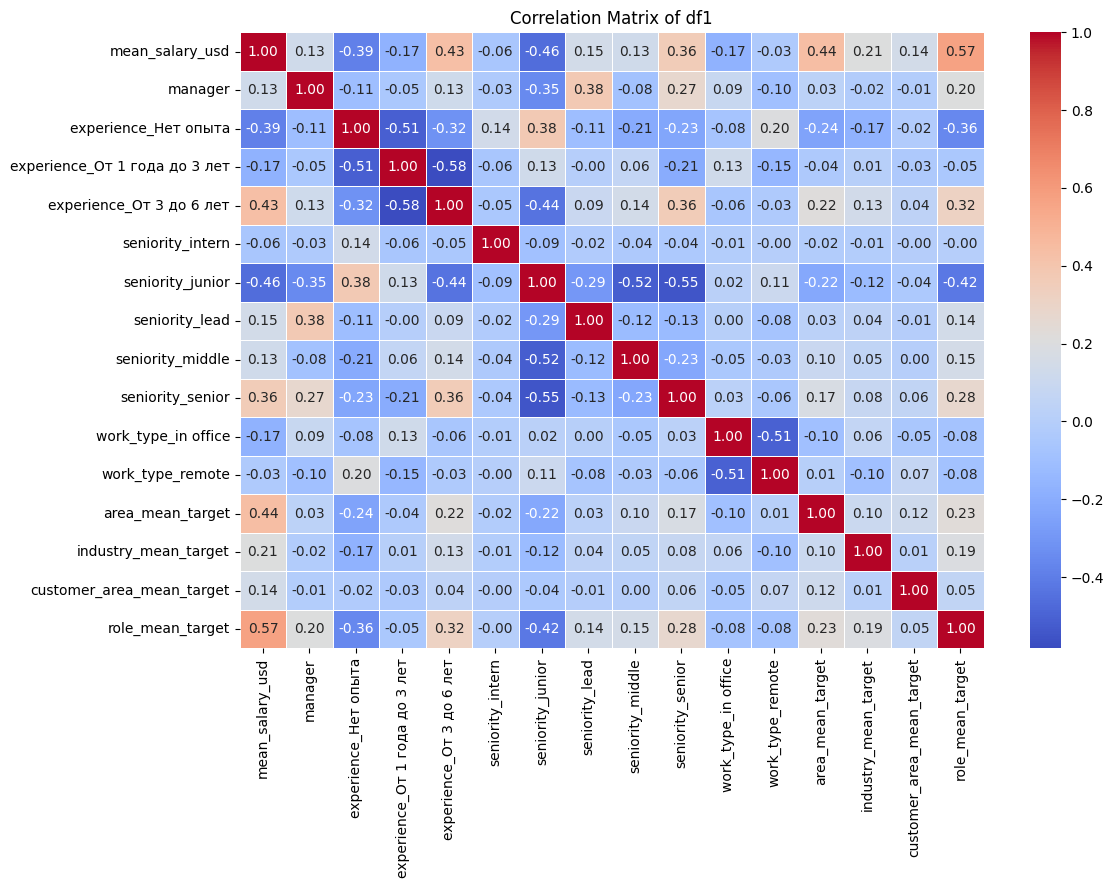

In [57]:
df1 = df.drop(columns=['professional_roles', 'key_skills', 'mean_salary', 'salary_from', 'salary_to', 'id', 'published_at', 'published_date', 'languages', 'name', 'salary', 'employer', 'currency', 'education','employment', 'schedule', 'tech_stack', 'tech_skills_v2', 'tech_skills_v3', 'description_summary_en', 'preproc_summary_en'])

corr_matrix = df1.drop(columns=['tech_stack_embedding', 'description']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of df1')
plt.show()

In [16]:
def weighted_mape(y_true, y_pred, weights=None):
    """
    Calculate the Weighted Mean Absolute Percentage Error (Weighted MAPE).
    
    Parameters:
    - y_true: array-like of shape (n_samples,) - Ground truth (correct) target values.
    - y_pred: array-like of shape (n_samples,) - Estimated target values.
    - weights: array-like of shape (n_samples,), optional - Weights for each sample. If None, use y_true as weights.
    
    Returns:
    - weighted_mape_value: float - The weighted MAPE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Default weights to y_true if not provided
    if weights is None:
        weights = np.abs(y_true)
    
    # Calculate the absolute percentage error
    ape = np.abs((y_true - y_pred) / y_true)
    
    # Weighted Mean Absolute Percentage Error
    weighted_mape_value = np.sum(weights * ape) / np.sum(weights) * 100
    
    return weighted_mape_value

In [17]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

def evaluate(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    wmape = weighted_mape(y_test, y_pred)

    return {
        "r2": r2,
        "mae": mae,
        "mape": mape,
        "wmape": wmape,
    }

In [58]:
from sklearn.model_selection import train_test_split

X = df1.drop(columns=['mean_salary_usd'])
y = df1['mean_salary_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

0:	learn: 0.1554240	test: 0.1535360	best: 0.1535360 (0)	total: 747ms	remaining: 12m 26s
1:	learn: 0.1462445	test: 0.1443355	best: 0.1443355 (1)	total: 1.54s	remaining: 12m 48s
2:	learn: 0.1394677	test: 0.1375147	best: 0.1375147 (2)	total: 2.3s	remaining: 12m 44s
3:	learn: 0.1331314	test: 0.1311410	best: 0.1311410 (3)	total: 3.07s	remaining: 12m 44s
4:	learn: 0.1268436	test: 0.1249669	best: 0.1249669 (4)	total: 3.83s	remaining: 12m 42s
5:	learn: 0.1213017	test: 0.1196205	best: 0.1196205 (5)	total: 4.61s	remaining: 12m 43s
6:	learn: 0.1167654	test: 0.1152056	best: 0.1152056 (6)	total: 5.38s	remaining: 12m 42s
7:	learn: 0.1127386	test: 0.1113307	best: 0.1113307 (7)	total: 6.14s	remaining: 12m 41s
8:	learn: 0.1095858	test: 0.1082046	best: 0.1082046 (8)	total: 6.91s	remaining: 12m 40s
9:	learn: 0.1062783	test: 0.1049525	best: 0.1049525 (9)	total: 7.67s	remaining: 12m 39s
10:	learn: 0.1033425	test: 0.1021969	best: 0.1021969 (10)	total: 8.43s	remaining: 12m 38s
11:	learn: 0.1008446	test: 0.09

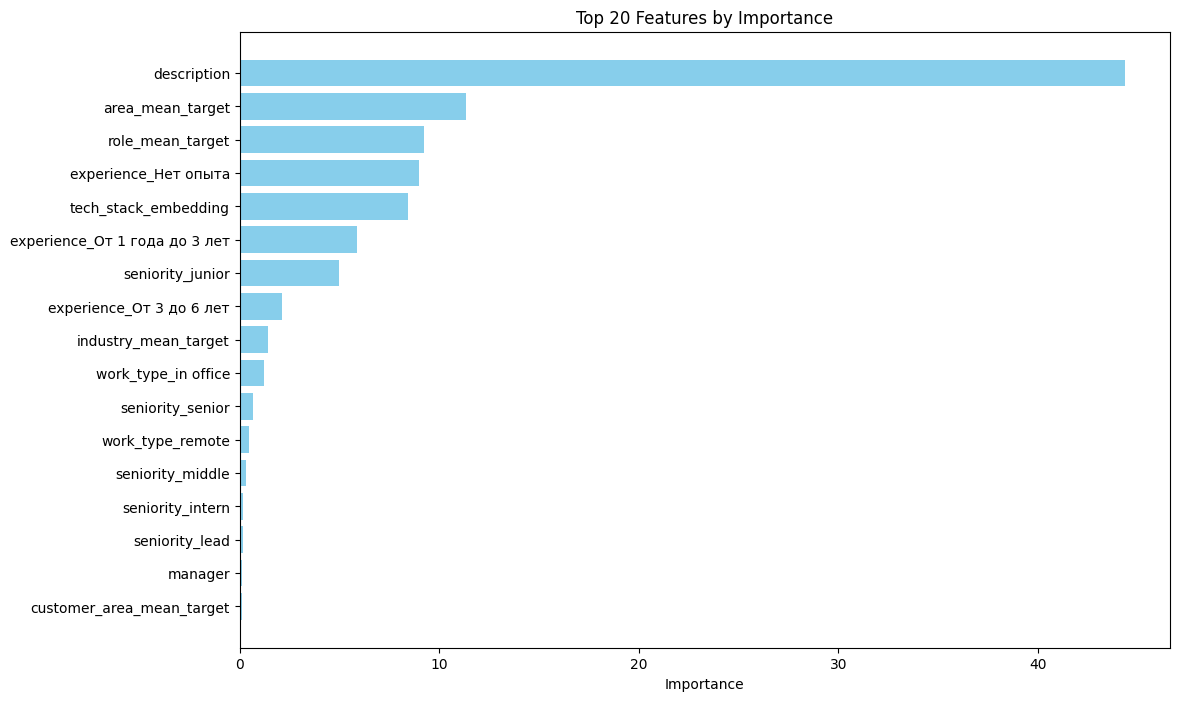

In [59]:
from catboost import CatBoostRegressor, Pool

from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')

y_train_tf = qt.fit_transform(y_train.values.reshape(-1, 1))
y_test_tf = qt.fit_transform(y_test.values.reshape(-1, 1))

y_train_lt = np.log1p(y_train)
y_test_lt= np.log1p(y_test)

train_pool = Pool(
    X_train, 
    y_train_lt, 
    embedding_features=['tech_stack_embedding'],
    text_features=['description'],
)
test_pool = Pool(
    X_test, 
    y_test_lt, 
    embedding_features=['tech_stack_embedding'],
    text_features=['description'],
)

pcts = [0.1, 0.5, 0.9]

optimal_params = {
    'iterations': 1000,
    'depth': 10,
    'learning_rate': 0.1,
}

cb_model_qt = CatBoostRegressor(
    **optimal_params,
    early_stopping_rounds=50,
    l2_leaf_reg=1,
    loss_function=f"MultiQuantile:alpha={','.join(map(str, pcts))}",
    # loss_function="MAE",
)
cb_model_qt.fit(train_pool, eval_set=test_pool)

# y_pred_cb = qt.inverse_transform(catboost_model.predict(X_test).reshape(-1, 1))
# y_pred_cb = catboost_model.predict(X_test)
y_pred_cb = np.expm1(cb_model_qt.predict(X_test))

feature_importances = cb_model_qt.get_feature_importance()
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'][:50], feature_importance_df['importance'][:50], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Features by Importance')
plt.gca().invert_yaxis()

In [60]:
sorted_indices = np.argsort(y_test)

sorted_y_test = y_test.iloc[sorted_indices][:-20]
sorted_y_pred_cb = y_pred_cb[sorted_indices][:-20]

{'r2': 0.7138632564265595, 'mae': 328.1433454419327, 'mape': 0.24419011214710828, 'wmape': 23.335796072096993}


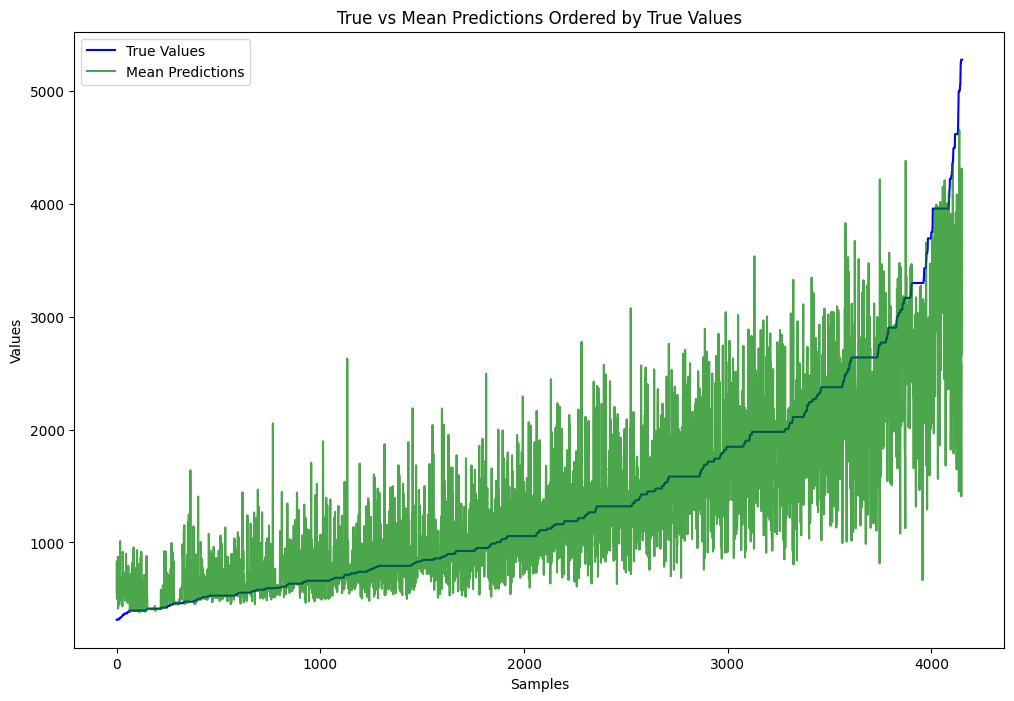

In [77]:
qt = 1

print(evaluate(sorted_y_test, sorted_y_pred_cb[:, qt]))

plt.figure(figsize=(12, 8))
plt.plot(sorted_y_test.values, label='True Values', color='blue')
plt.plot(sorted_y_pred_cb[:, qt], label='Mean Predictions', color='green', alpha=0.7)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('True vs Mean Predictions Ordered by True Values')
plt.legend()
plt.show()